HARTH shape after filtering: (764815, 8)
[INFO] Starting feature extraction...
[INFO] Extracted 3096 windows.
Extracted feature shape: (3096, 48)
✅ Accuracy on HARTH: 0.8888888888888888
✅ Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.99      0.68       362
           3       0.00      0.00      0.00        94
           4       0.00      0.00      0.00        56
           5       0.00      0.00      0.00        53
           6       0.98      0.76      0.86       504
           7       1.00      0.99      0.99      1730
           8       1.00      1.00      1.00       297

    accuracy                           0.89      3096
   macro avg       0.50      0.53      0.50      3096
weighted avg       0.87      0.89      0.87      3096



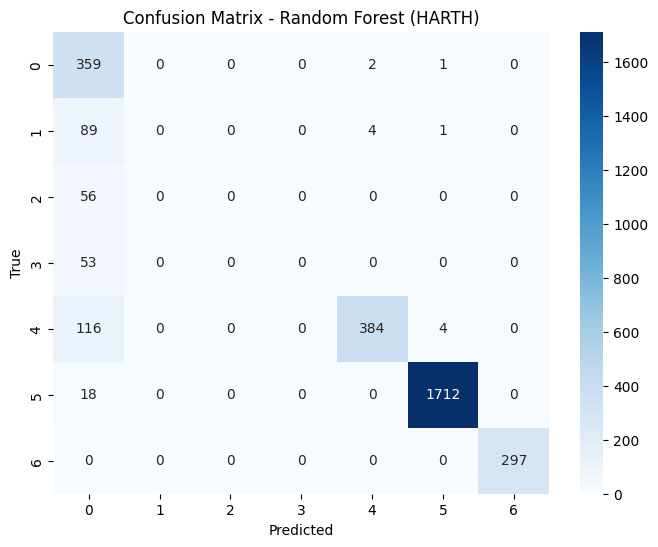

In [5]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import mode
from collections import Counter
import os
import glob
import joblib
import warnings
warnings.filterwarnings('ignore')

# 2. Load and preprocess HARTH data
file_paths = glob.glob('/Users/spartan/Desktop/MLproject/harth/*.csv')
file_paths = file_paths[3:5]  # Optional: limit for testing

df_harth = pd.DataFrame()
for file in file_paths:
    df = pd.read_csv(file)
    df_harth = pd.concat([df_harth, df], axis=0)

df_harth = df_harth.drop(columns=['index', 'Unnamed: 0'], errors='ignore')
df_harth['timestamp'] = pd.to_datetime(df_harth['timestamp'])
df_harth = df_harth.sort_values('timestamp')

# Keep only valid activity labels
valid_labels = [1, 3, 4, 5, 6, 7, 8]
df_harth = df_harth[df_harth['label'].isin(valid_labels)]
print("HARTH shape after filtering:", df_harth.shape)

# 3. Feature extraction: FFT + Stat (no temporal)
def extract_fft_stat_features(window_df, sampling_rate=50):
    features = {}
    sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
    window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)

    for col in sensor_cols + ['back_mag', 'thigh_mag']:
        arr = window_df[col].to_numpy()
        fft_vals = np.abs(fft(arr))
        n = len(arr)
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        dom_idx = np.argmax(fft_vals[1:]) + 1
        dom_freq = abs(freqs[dom_idx])
        spectral_energy = np.sum(fft_vals**2)

        features[f'{col}_dom_freq_hz'] = dom_freq
        features[f'{col}_spectral_energy'] = spectral_energy
        features[f'{col}_mean'] = np.mean(arr)
        features[f'{col}_std'] = np.std(arr)
        features[f'{col}_median'] = np.median(arr)
        features[f'{col}_mode'] = mode(arr, keepdims=False)[0]

    return features

# 4. Apply sliding window + feature aggregation
def extract_features_from_dataframe(df, window_size_seconds=5, sampling_rate=50):
    features_list = []
    labels_list = []
    start_idx = 0
    total_samples = df.shape[0]

    print("[INFO] Starting feature extraction...")

    while start_idx < total_samples:
        start_time = df.iloc[start_idx]['timestamp']
        end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
        window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]

        if len(window_df) < 10:
            start_idx += 1
            continue

        features = extract_fft_stat_features(window_df)
        majority_label = Counter(window_df['label']).most_common(1)[0][0]

        features_list.append(features)
        labels_list.append(majority_label)
        start_idx += len(window_df)

    print(f"[INFO] Extracted {len(features_list)} windows.")
    return pd.DataFrame(features_list), np.array(labels_list)

# 5. Run feature extraction
X_harth, y_harth = extract_features_from_dataframe(df_harth)
print("Extracted feature shape:", X_harth.shape)

# 6. Load trained model
rf_model_loaded = joblib.load('best_rf_model_fft_stat.pkl')

# 7. Align columns with training feature order
X_harth = X_harth[rf_model_loaded.feature_names_in_]

# 8. Predict and evaluate
y_pred = rf_model_loaded.predict(X_harth)

print("Accuracy on HARTH:", accuracy_score(y_harth, y_pred))
print("Classification Report:\n", classification_report(y_harth, y_pred))

cm = confusion_matrix(y_harth, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (HARTH)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('test_7_class.png')
plt.show()


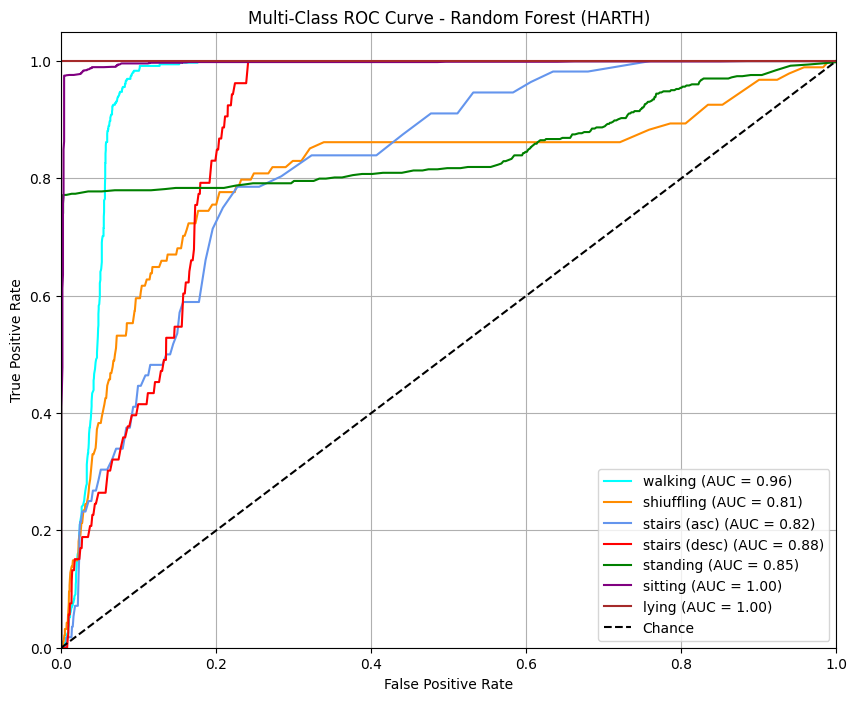

In [8]:
labels_dic = {
    1: 'walking', 3: "shiuffling", 4: "stairs (asc)",
    5: "stairs (desc)", 6: "standing", 7: "sitting", 8: "lying"
}

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_harth, classes=list(labels_dic.keys()))
y_prob = rf_model_loaded.predict_proba(X_harth)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_id in enumerate(labels_dic.keys()):
    fpr[class_id], tpr[class_id], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])

for class_id, color in zip(labels_dic.keys(), colors):
    plt.plot(fpr[class_id], tpr[class_id], color=color,
             label=f"{labels_dic[class_id]} (AUC = {roc_auc[class_id]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve - Random Forest (HARTH)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve_multiclass.png')
plt.show()
